## Final Assignment: Problem Formulation

For this project you work with real data from Airbnb with the goal is to explore the data and build a tool to get an estimate for a new listening in Stockholm. Imagine you have an apartment in Stockholm and would like to rent it out via Airbnb. What price should you set? Minimum nights per stay? What amenities do you need to stick out against the hard competition in Stockholm? What are important keywords in your title and description? These and many other questions are important to answer. With the provided data you can find an answer to the question.

 

The tool you create, should take an address, number of rooms and different amenities (dryer, oven, smoke alarm) as an input and provide the user with an estimate rental price per night. Additionally provide information how you would stick out against the competition.
Here the functionality of the tool is most important rather than a perfect designed user interface.

 

## Loading Libraries and Dataset

In [1]:
import pandas as pd  # For data manipulation and reading CSV files
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt # For plotting graphs
import seaborn as sns # For enhanced data visualization
import io
import ast # For safely evaluating string representations of lists (like amenities)
from datetime import datetime # To handle date calculations
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # ignore pandas FutureWarnings
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, randint
import re # Import the regular expression module



# Set some display options for pandas DataFrames for better readability
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)     
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
try:
    file_path = 'listings.csv' 

    # Load the dataset
    df_raw = pd.read_csv(file_path)
    df = df_raw.copy()

    print(f"Dataset loaded successfully from: {file_path}")
    print(f"Dataset shape (rows, columns): {df.shape}")

except FileNotFoundError:
    print(f"Error: The file was not found at the specified path: {file_path}")
    print("Please ensure the file path is correct.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Dataset loaded successfully from: listings.csv
Dataset shape (rows, columns): (5223, 75)


## Initial Data Exploration

In [3]:
if 'df' in locals():
    print("\n--- Initial Data Exploration ---")

    # 1. Display the first few rows
    print("\n1. First 5 rows of the dataset:")
    display(df.head()) 

    # 2. Display concise summary of the DataFrame
    print("\n2. DataFrame Info (Column Types and Non-Null Counts):")
    df.info() 

    # 3. Display basic descriptive statistics for numerical columns
    print("\n3. Descriptive Statistics for Numerical Columns:")
    display(df.describe())

    # 4. Display basic descriptive statistics for object (text/categorical) columns
    print("\n4. Descriptive Statistics for Object/Categorical Columns:")
    display(df.describe(include='object'))

    # 5. Check for missing values (showing percentage)
    print("\n5. Percentage of Missing Values per Column (sorted):")
    missing_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    # Filter to show only columns with missing values
    missing_percentage = missing_percentage[missing_percentage > 0]
    if not missing_percentage.empty:
      print(missing_percentage)
    else:
      print("No missing values found.")


    # 6. Check the number of unique values in each column
    print("\n6. Number of Unique Values per Column:")
    unique_counts = df.nunique().sort_values()
    print(unique_counts)

    # 7. Quick check on the target variable 'price' if it exists
    if 'price' in df.columns:
        print("\n7. Initial check on the 'price' column:")
        print(f"   Data type: {df['price'].dtype}")
        # Show some example values if it's an object type (likely needs cleaning)
        if df['price'].dtype == 'object':
            print(f"   Example values: {df['price'].dropna().unique()[:10]}") 
        else:
             # If already numeric, show range
             print(f"   Min price: {df['price'].min()}, Max price: {df['price'].max()}")
    else:
        print("\nWarning: 'price' column not found in the dataset.")

else:
    print("\nSkipping Initial EDA because the DataFrame 'df' was not loaded.")


--- Initial Data Exploration ---

1. First 5 rows of the dataset:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,164448,https://www.airbnb.com/rooms/164448,20241230011645,2024-12-30,city scrape,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,NaN,https://a0.muscache.com/pictures/f56d8d10-a7fa...,784312,https://www.airbnb.com/users/show/784312,Li,2011-07-06,"Stockholm, Sweden","I am a recently retired lady, who has two room...",within an hour,100%,100%,t,https://a0.muscache.com/im/users/784312/profil...,https://a0.muscache.com/im/users/784312/profil...,Södermalm,2,2,"['email', 'phone']",t,t,NaN,Södermalms,NaN,59.314,18.061,Private room in rental unit,Private room,2,1.000,1 shared bath,1.000,2.000,"[""Hair dryer"", ""Hangers"", ""Long term stays all...",$944.00,2,120,2,2,120,120,2.000,120.000,NaN,t,27,57,87,177,2024-12-30,430,30,1,2011-07-30,2024-12-09,4.860,4.870,4.790,4.950,4.970,4.840,4.760,NaN,f,2,0,2,0,2.630
1,220851,https://www.airbnb.com/rooms/220851,20241230011645,2024-12-30,city scrape,One room in appartement,Welcome!,Many restaurangs wery close and walkingdistanc...,https://a0.muscache.com/pictures/2085606/7a706...,412283,https://www.airbnb.com/users/show/412283,Fredric,2011-02-27,"Stockholm, Sweden",I am into arts yoga meditation design life rel...,within a day,100%,15%,f,https://a0.muscache.com/im/pictures/user/e0c05...,https://a0.muscache.com/im/pictures/user/e0c05...,Kungsholmen,2,4,"['email', 'phone']",t,t,"Stockholm, Stockholm County, Sweden",Kungsholmens,NaN,59.334,18.037,Private room in rental unit,Private room,1,1.000,1 shared bath,1.000,1.000,"[""Hangers"", ""Apple sound system with aux"", ""P...",$414.00,2,20,2,2,20,20,2.000,20.000,NaN,t,25,55,85,360,2024-12-30,64,1,0,2011-09-29,2024-08-30,4.680,4.700,4.630,4.870,4.880,4.810,4.700,NaN,f,2,1,1,0,0.400
2,238411,https://www.airbnb.com/rooms/238411,20241230011645,2024-12-30,city scrape,Cozy apartment in central Stockholm,NaN,"Restaurants, cafés, museums, art galleries, pa...",https://a0.muscache.com/pictures/2806060/7fc68...,1250232,https://www.airbnb.com/users/show/1250232,Mia,2011-10-05,"Stockholm, Sweden",I am from Stockholm. I'm passionate about trav...,within a few hours,100%,0%,f,https://a0.muscache.com/im/users/1250232/profi...,https://a0.muscache.com/im/users/1250232/profi...,Norrmalm,1,1,"['email', 'phone']",t,t,"Stockholm, Stockholm County, Sweden",Norrmalms,NaN,59.339,18.051,Entire rental unit,Entire home/apt,2,1.000,1 bath,1.000,2.000,"[""Washer"", ""Hair dryer"", ""Hangers"", ""Long term...","$1,320.00",1,60,1,1,60,60,1.000,60.000,NaN,t,28,58,88,88,2024-12-30,110,0,0,2011-11-28,2016-12-13,4.790,4.650,4.710,4.850,4.950,4.850,4.640,NaN,f,1,1,0,0,0.690
3,242188,https://www.airbnb.com/rooms/242188,20241230011645,2024-1


2. DataFrame Info (Column Types and Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5223 non-null   int64  
 1   listing_url                                   5223 non-null   object 
 2   scrape_id                                     5223 non-null   int64  
 3   last_scraped                                  5223 non-null   object 
 4   source                                        5223 non-null   object 
 5   name                                          5223 non-null   object 
 6   description                                   5006 non-null   object 
 7   neighborhood_overview                         1901 non-null   object 
 8   picture_url                                   5223 non-null   object 
 9   host_id 

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,5223.000,5223.000,5223.000,5223.000,5223.000,0.000,5223.000,5223.000,5223.000,3496.000,4914.000,3495.000,5223.000,5223.000,5223.000,5223.000,5223.000,5223.000,5223.000,5223.000,0.000,5223.000,5223.000,5223.000,5223.000,5223.000,5223.000,5223.000,4160.000,4160.000,4160.000,4160.000,4160.000,4160.000,4160.000,0.000,5223.000,5223.000,5223.000,5223.000,4160.000
mean,615271881759993984.000,20241230011645.000,182750157.987,9.875,18.960,NaN,59.318,18.031,3.452,1.270,1.703,2.120,7.336,331.362,6.856,7.847,421.209,442.352,7.539,431.956,NaN,11.742,25.071,38.839,135.412,27.752,8.415,0.491,4.808,4.812,4.748,4.860,4.870,4.814,4.727,NaN,4.629,4.149,0.451,0.008,1.142
std,515664380057263488.000,1.723,192404576.228,90.592,249.012,NaN,0.031,0.065,1.946,0.625,1.171,1.745,26.294,378.695,25.314,26.817,435.793,516.378,26.379,437.043,NaN,12.347,25.238,38.116,135.456,65.706,21.831,1.544,0.359,0.356,0.405,0.329,0.326,0.307,0.383,NaN,11.033,11.049,1.699,0.132,2.286
min,164448.000,20241230011645.000,4457.000,1.000,1.000,NaN,59.232,17.773,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.000,0.000,0.000,0.010
25%,35777829.000,20241230011645.000,23243281.500,1.000,1.000,NaN,59.298,18.001,2.000,1.000,1.000,1.000,1.000,30.000,1.000,2.000,30.000,30.000,2.000,30.000,NaN,0.000,0.000,0.000,0.000,1.000,0.000,0.000,4.750,4.760,4.670,4.850,4.860,4.750,4.650,NaN,1.000,1.000,0.000,0.000,0.180
50%,801168019967339520.000,20241230011645.000,91345583.000,1.000,2.000,NaN,59.317,18.046,3.000,1.000,1.000,2.000,3.000,300.000,2.000,3.000,365.000,365.000,3.000,365.000,NaN,6.000,16.000,29.000,88.000,6.000,2.000,0.000,4.920,4.920,4.870,4.960,5.000,4.910,4.810,NaN,1.000,1.000,0.000,0.000,0.450
75%,1110622784882269440.000,20241230011645.000,325885492.000,2.000,3.000,NaN,59.338,18.076,4.000,1.500,2.000,3.000,5.000,365.000,4.000,5.000,999.000,1125.000,5.000,1039.300,NaN,26.000,55.000,83.000,268.000,22.000,7.000,0.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,NaN,2.000,1.000,0.000,0.000,1.220
max,1321949733901820416.000,20241230011645.000,669352745.000,3284.000,8065.000,NaN,59.419,18.188,16.000,12.000,12.000,26.000,500.000,1125.000,500.000,500.000,1125.000,20000.000,500.000,3051.000,NaN,30.000,60.000,90.000,365.000,1174.000,711.000,54.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,NaN,69.000,69.000,21.000,3.000,76.450



4. Descriptive Statistics for Object/Categorical Columns:


,listing_url,last_scraped,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,price,has_availability,calendar_last_scraped,first_review,last_review,instant_bookable
count,5223,5223,5223,5223,5006,1901,5223,5223,5223,5223,4269,2276,3071,3071,4147,5199,5223,5223,1485,5223,5223,5223,1901,5223,5223,5223,5214,5223,3498,5027,5223,4160,4160,5223
unique,5223,1,2,5068,4723,1672,5170,4172,1672,2592,123,1623,4,47,101,2,3968,3968,24,5,2,2,87,14,43,4,26,4920,1271,2,1,1848,883,2
top,https://www.airbnb.com/rooms/164448,2024-12-30,city scrape,Lägenhet Stockholm,Live the simple life in this peaceful and cent...,The apartment Is located in the heart of Stock...,https://a0.muscache.com/pictures/miso/Hosting-...,https://www.airbnb.com/users/show/271346174,Anna,2019-06-25,"Stockholm, Sweden",Born and raised in Stockholm and work as a pro...,within an hour,100%,100%,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Södermalm,"['email', 'phone']",t,t,"Stockholm, Stockholms län, Sweden",Södermalms,Entire rental unit,Entire home/apt,1 bath,"[""Washer"", ""TV"", ""Kitchen"", ""Wifi"", ""Smoke ala...","$2,500.00",t,2024-12-30,2024-05-19,2024-12-15,f
freq,1,5223,3498,23,23,34,6,69,97,69,3923,49,1686,2193,1058,4263,217,217,549,3989,5006,4612,406,1317,2947,4316,3048,28,91,5022,5223,72,114,4512



5. Percentage of Missing Values per Column (sorted):
neighbourhood_group_cleansed   100.000
license                        100.000
calendar_updated               100.000
host_neighbourhood              71.568
neighborhood_overview           63.603
neighbourhood                   63.603
host_about                      56.424
host_response_rate              41.202
host_response_time              41.202
beds                            33.084
bathrooms                       33.065
price                           33.027
host_acceptance_rate            20.601
reviews_per_month               20.352
last_review                     20.352
review_scores_rating            20.352
review_scores_accuracy          20.352
review_scores_cleanliness       20.352
review_scores_checkin           20.352
review_scores_communication     20.352
review_scores_location          20.352
review_scores_value             20.352
first_review                    20.352
host_location                   18.265
bedrooms  

## Data Preprocessing

In [4]:
# Make sure 'df' DataFrame exists from the previous steps
if 'df' not in locals():
    print("Error: DataFrame 'df' not found. Please run the data loading step first.")
else:
    print(f"Starting cleaning process on DataFrame with shape: {df.shape}")

    # --- 1. Drop Unnecessary or Redundant Columns ---
    # Based on EDA: 100% missing, IDs, URLs, free text (for now), metadata, redundant cols

    columns_to_drop = [
        # 100% Missing
        'neighbourhood_group_cleansed', 'license', 'calendar_updated',
        # IDs / URLs / Metadata
        'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url',
        'host_id', 'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url',
        'calendar_last_scraped',
        # Free text (can revisit later for NLP if needed)
        'description', 'neighborhood_overview', 'host_about', 'name',
        # Redundant / High Missing % / Less Useful Location info
        'neighbourhood', # Using neighbourhood_cleansed
        'host_neighbourhood', # Very high missing %
        # Redundant host counts (keeping host_total_listings_count and calculated_host_listings_count)
        'host_listings_count',
        'calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms',
        'calculated_host_listings_count_shared_rooms',
        # Redundant nights variables (keeping minimum_nights, maximum_nights)
        'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
        'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
        # Redundant review counts (keeping number_of_reviews, reviews_per_month)
        'number_of_reviews_ltm', 'number_of_reviews_l30d',
        # Redundant/Less useful bathrooms col (will parse bathrooms_text)
        'bathrooms'
    ]

    # Drop the columns, using errors='ignore' in case some columns were already dropped or don't exist
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    print(f"Dropped {len(columns_to_drop)} columns. New shape: {df.shape}")

    # --- 2. Clean Target Variable ('price') ---
    # Convert price from object (string with $ and ,) to float
    # Also drop rows where price is missing, as they cannot be used for training/evaluation

    if 'price' in df.columns:
        # Drop rows where price is NaN *before* attempting conversion
        original_rows = df.shape[0]
        df.dropna(subset=['price'], inplace=True)
        print(f"Dropped {original_rows - df.shape[0]} rows with missing 'price'. New shape: {df.shape}")

        # Clean the price string and convert to float
        try:
            df['price'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True).astype(float)
            print("Cleaned 'price' column: removed '$', ',', and converted to float.")
            # Display stats for the cleaned price
            print("\nDescriptive statistics for cleaned 'price':")
            display(df['price'].describe())
        except Exception as e:
            print(f"Error cleaning 'price' column: {e}")
    else:
        print("Warning: 'price' column not found, skipping price cleaning.")


    # --- 3. Convert Boolean-like Columns ('t'/'f') to Binary (1/0) ---
    bool_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
                 'has_availability', 'instant_bookable']

    for col in bool_cols:
        if col in df.columns:
            # Impute potential NaNs with the mode (most frequent value, likely 'f') before mapping
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            # Map 't' to 1 and 'f' to 0
            df[col] = np.where(df[col] == 't', 1, 0)
            print(f"Converted '{col}' to binary (1/0).")

    print(f"Converted boolean-like columns {bool_cols} to binary (1/0).")


    # --- 4. Clean and Convert Percentage Columns ---
    # host_response_rate, host_acceptance_rate
    percent_cols = ['host_response_rate', 'host_acceptance_rate']
    for col in percent_cols:
        if col in df.columns:
            # Convert to string, remove '%', convert to float, divide by 100
            df[col] = df[col].astype(str).str.replace('%', '', regex=False).astype(float) / 100.0
            # Missing values will be handled later (imputation)
            print(f"Cleaned and converted '{col}' to float (0-1 scale).") 

    print(f"Cleaned percentage columns {percent_cols} (converted to 0-1 float scale).")


    # --- 5. Convert Date Columns and Engineer Host Duration ---
    date_cols = ['host_since', 'first_review', 'last_review']
    current_time = datetime.now() # Use current time for calculations like host duration

    for col in date_cols:
        if col in df.columns:
            # Convert to datetime objects, coercing errors will turn unparseable dates into NaT (Not a Time)
            df[col] = pd.to_datetime(df[col], errors='coerce')
            print(f"Converted '{col}' to datetime objects.")

    # Engineer host_duration_days
    if 'host_since' in df.columns and pd.api.types.is_datetime64_any_dtype(df['host_since']):
        df['host_duration_days'] = (current_time - df['host_since']).dt.days
        # Handle potential NaT in host_since (which result in NaT in duration) - imputation later
        print("Engineered 'host_duration_days' feature.")
    else:
         print("Could not engineer 'host_duration_days': 'host_since' column missing or not datetime.")

    print(f"Converted date columns {date_cols} to datetime objects.")


    # --- 6. Parse 'bathrooms_text' ---
    # Extract number of baths and type (shared/private)

    if 'bathrooms_text' in df.columns:
        # Fill the few missing values with the mode
        mode_bath_text = df['bathrooms_text'].mode()[0]
        df['bathrooms_text'].fillna(mode_bath_text, inplace=True)
        print(f"Imputed {df['bathrooms_text'].isnull().sum()} missing values in 'bathrooms_text' with mode ('{mode_bath_text}').") # Should be 0 now

        # Extract number of baths (handles floats like 1.5, half-bath as 0.5)
        df['num_bathrooms'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
        # Handle 'Half-bath' specifically if the regex didn't catch it properly or if represented differently
        df['num_bathrooms'] = df['num_bathrooms'].fillna(0.5).where(df['bathrooms_text'].str.contains('Half-bath', case=False, na=False), df['num_bathrooms'])
        # Default to 1 bath if extraction failed and it's not a half-bath (e.g., just 'Private bath')
        df['num_bathrooms'].fillna(1.0, inplace=True)


        # Extract bath type (shared/private) - create a binary flag 'is_shared_bath'
        df['is_shared_bath'] = df['bathrooms_text'].str.contains('shared', case=False, na=False).astype(int)

        print("Parsed 'bathrooms_text': created 'num_bathrooms' (float) and 'is_shared_bath' (binary).")
        # Can drop the original column now
        df.drop(columns=['bathrooms_text'], inplace=True, errors='ignore')

    else:
        print("Warning: 'bathrooms_text' column not found, skipping parsing.")


    # --- 7. Parse 'amenities' ---
    # Convert string representation of list into actual list, then count amenities

    if 'amenities' in df.columns:
        # Function to safely parse the string representation of a list
        def parse_stringified_list(s):
            try:
                # Handle empty lists "[]" or potential variations
                if isinstance(s, str) and s.strip() and s.strip() != '[]':
                    # ast.literal_eval is safer than eval()
                    parsed_list = ast.literal_eval(s)
                    return parsed_list if isinstance(parsed_list, list) else []
                else:
                    return []
            except (ValueError, SyntaxError):
                # Return empty list if parsing fails
                return []

        df['amenities_list'] = df['amenities'].apply(parse_stringified_list)
        df['num_amenities'] = df['amenities_list'].apply(len)

        print("Parsed 'amenities': created 'amenities_list' and 'num_amenities'.")
        # Keep 'amenities_list' for potential multi-hot encoding later
        # Drop the original raw 'amenities' string column
        df.drop(columns=['amenities'], inplace=True, errors='ignore')
    else:
        print("Warning: 'amenities' column not found, skipping parsing.")


    # --- 8. Parse 'host_verifications' ---
    if 'host_verifications' in df.columns:
        # Use the same parsing function as for amenities
        df['verifications_list'] = df['host_verifications'].apply(parse_stringified_list)
        df['num_host_verifications'] = df['verifications_list'].apply(len)

        print("Parsed 'host_verifications': created 'verifications_list' and 'num_host_verifications'.")
        # Keep 'verifications_list' for potential feature engineering if needed
        # Drop the original raw 'host_verifications' string column
        df.drop(columns=['host_verifications'], inplace=True, errors='ignore')
    else:
         print("Warning: 'host_verifications' column not found, skipping parsing.")


    # --- 9. Handle Remaining Missing Values (Imputation) ---
    print("\n--- Handling Remaining Missing Values ---")

    # Strategy:
    # - Numerical: Impute with median (robust to outliers) or 0 where it makes sense (reviews).
    # - Categorical: Impute with a specific category like 'Unknown'.
    # - Datetime: Leave as NaT for now, or impute derived features (like duration).

    # Numerical Imputation
    num_cols_to_impute = {
        'host_response_rate': df['host_response_rate'].median(),
        'host_acceptance_rate': df['host_acceptance_rate'].median(),
        'bedrooms': df['bedrooms'].median(),
        'beds': df['beds'].median(), # High missing %, median is a simple start
        'host_duration_days': df['host_duration_days'].median(), # If host_since was missing
        # Review-related columns: Impute with 0 where number_of_reviews is 0
        'review_scores_rating': 0, 'review_scores_accuracy': 0, 'review_scores_cleanliness': 0,
        'review_scores_checkin': 0, 'review_scores_communication': 0, 'review_scores_location': 0,
        'review_scores_value': 0, 'reviews_per_month': 0
    }

    for col, fill_value in num_cols_to_impute.items():
        if col in df.columns:
            original_nan_count = df[col].isnull().sum()
            if original_nan_count > 0:
                # Special handling for review scores/reviews per month: only impute if number_of_reviews > 0?
                # Simpler approach: Impute all NaNs first. If col is reviews_per_month or review_scores*, impute with 0.
                if col.startswith('review_scores_') or col == 'reviews_per_month':
                     df[col].fillna(0, inplace=True)
                     print(f"Imputed {original_nan_count} missing values in '{col}' with 0.")
                else:
                    df[col].fillna(fill_value, inplace=True)
                    print(f"Imputed {original_nan_count} missing values in '{col}' with median ({fill_value:.3f}).")

    # Categorical Imputation
    cat_cols_to_impute = {
        'host_response_time': 'Unknown', # Create a new category
        'host_location': 'Unknown'     # Create a new category
    }
    for col, fill_value in cat_cols_to_impute.items():
         if col in df.columns:
            original_nan_count = df[col].isnull().sum()
            if original_nan_count > 0:
                df[col].fillna(fill_value, inplace=True)
                print(f"Imputed {original_nan_count} missing values in '{col}' with '{fill_value}'.")

    
    # --- 10. Final Check ---
    print("\n--- Final Check after Cleaning and Preprocessing ---")

    print("\n1. Remaining Missing Values per Column:")
    final_missing = df.isnull().sum()
    final_missing = final_missing[final_missing > 0]
    if not final_missing.empty:
        print(final_missing)
    else:
        print("No remaining missing values found (excluding potential NaTs in datetime columns).")

    print("\n2. DataFrame Info after Cleaning:")
    buffer = io.StringIO()
    df.info(buf=buffer, verbose=True)
    info_str = buffer.getvalue()
    print(info_str)

    print("\n3. First 5 rows of the cleaned DataFrame:")
    display(df.head())

    print("\nData cleaning and preprocessing step completed.")

Starting cleaning process on DataFrame with shape: (5223, 75)
Dropped 33 columns. New shape: (5223, 42)
Dropped 1725 rows with missing 'price'. New shape: (3498, 42)
Cleaned 'price' column: removed '$', ',', and converted to float.

Descriptive statistics for cleaned 'price':


count     3498.000
mean      2140.879
std      10108.348
min        105.000
25%        838.250
50%       1300.000
75%       2181.000
max     500000.000
Name: price, dtype: float64

Converted 'host_is_superhost' to binary (1/0).
Converted 'host_has_profile_pic' to binary (1/0).
Converted 'host_identity_verified' to binary (1/0).
Converted 'has_availability' to binary (1/0).
Converted 'instant_bookable' to binary (1/0).
Converted boolean-like columns ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable'] to binary (1/0).
Cleaned and converted 'host_response_rate' to float (0-1 scale).
Cleaned and converted 'host_acceptance_rate' to float (0-1 scale).
Cleaned percentage columns ['host_response_rate', 'host_acceptance_rate'] (converted to 0-1 float scale).
Converted 'host_since' to datetime objects.
Converted 'first_review' to datetime objects.
Converted 'last_review' to datetime objects.
Engineered 'host_duration_days' feature.
Converted date columns ['host_since', 'first_review', 'last_review'] to datetime objects.
Imputed 0 missing values in 'bathrooms_text' with mode ('1 bath').
Parsed 'bathrooms_text': cre

,id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,host_duration_days,num_bathrooms,is_shared_bath,amenities_list,num_amenities,verifications_list,num_host_verifications
0,164448,2011-07-06,"Stockholm, Sweden",within an hour,1.000,1.000,1,2,1,1,Södermalms,59.314,18.061,Private room in rental unit,Private room,2,1.000,2.000,944.000,2,120,1,27,57,87,177,430,2011-07-30,2024-12-09,4.860,4.870,4.790,4.950,4.970,4.840,4.760,0,2,2.630,5057,1.000,1,"[Hair dryer, Hangers, Long term stays allowed,...",29,"[email, phone]",2
1,220851,2011-02-27,"Stockholm, Sweden",within a day,1.000,0.150,0,4,1,1,Kungsholmens,59.334,18.037,Private room in rental unit,Private room,1,1.000,1.000,414.000,2,20,1,25,55,85,360,64,2011-09-29,2024-08-30,4.680,4.700,4.630,4.870,4.880,4.810,4.700,0,2,0.400,5186,1.000,1,"[Hangers, Apple sound system with aux, Privat...",26,"[email, phone]",2
2,238411,2011-10-05,"Stockholm, Sweden",within a few hours,1.000,0.000,0,1,1,1,Norrmalms,59.339,18.051,Entire rental unit,Entire home/apt,2,1.000,2.000,1320.000,1,60,1,28,58,88,88,110,2011-11-28,2016-12-13,4.790,4.650,4.710,4.850,4.950,4.850,4.640,0,1,0.690,4966,1.000,0,"[Washer, Hair dryer, Hangers, Long term stays ...",29,"[email, phone]",2
3,242188,2011-07-06,"Stockholm, Sweden",within an hour,1.000,1.000,1,2,1,1,Södermalms,59.312,18.061,Private room in rental unit,Private room,1,1.000,1.000,814.000,2,300,1,30,60,90,180,414,2012-02-13,2024-12-01,4.900,4.880,4.840,4.960,4.980,4.890,4.840,0,2,2.640,5057,1.000,1,"[Hair dryer, Hangers, Fast wifi – 283 Mbps, Ho...",27,"[email, phone]",2
4,273906,2011-11-22,"Stockholm, Sweden",within a few hours,1.000,1.000,0,3,1,1,Södermalms,59.305,18.108,Entire rental unit,Entire home/apt,4,3.000,3.000,2750.000,6,30,1,2,2,2,9,4,2012-07-19,2017-07-31,5.000,5.000,5.000,5.000,4.750,5.000,5.000,0,2,0.030,4918,2.000,0,"[Washer, TV with standard cable, Dedicated wor...",8,"[email, phone, work_email]",3



Data cleaning and preprocessing step completed.


In [5]:
# Handling columns that still have null-values

# 1. We create a column to tell if a listing was never reviewd. We can get it from the number of reviews. This might be important
# to determine the price of new listings, and to see how it impacts prices of current listings
df['never_reviewed'] = (df['number_of_reviews'] == 0).astype(int)

reference_date = df['last_review'].max() # last observed revew in the dataset

# Days since last review: could be interesting for the regression to tell ho recent the last visit was to a listing
df['days_since_last_review'] = (reference_date - df['last_review']).dt.days

# Days since first review: it might be important to determine how "historically" this listing was. 
df['days_since_first_review'] = (reference_date - df['first_review']).dt.days

max_last = df['days_since_last_review'].max()
df['days_since_last_review'].fillna(max_last, inplace=True) # if a listing doesn't have any review, we put the max value here
df['days_since_first_review'].fillna(0, inplace=True) # if it was null, we put 0 
# these settings will likely be the same when trying to predict the price of NEW listings

df.drop(columns=['first_review', 'last_review'], inplace=True) # no loonger needed after new columns 

# Now we check again the dataset after these additional operations
print("\nDataFrame Info after (additional) Cleaning and Manipulation:")
buffer = io.StringIO()
df.info(buf=buffer, verbose=True)
info_str = buffer.getvalue()
print(info_str)




DataFrame Info after (additional) Cleaning and Manipulation:
<class 'pandas.core.frame.DataFrame'>
Index: 3498 entries, 0 to 5222
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              3498 non-null   int64         
 1   host_since                      3498 non-null   datetime64[ns]
 2   host_location                   3498 non-null   object        
 3   host_response_time              3498 non-null   object        
 4   host_response_rate              3498 non-null   float64       
 5   host_acceptance_rate            3498 non-null   float64       
 6   host_is_superhost               3498 non-null   int32         
 7   host_total_listings_count       3498 non-null   int64         
 8   host_has_profile_pic            3498 non-null   int32         
 9   host_identity_verified          3498 non-null   int32         
 10  neighbourhood_c

### Dataset backup after processing

In [6]:
# Save processed dataset
df.to_csv('listings_clean.csv', index=False)
print("Dataset saved in 'listings_clean.csv'")


Dataset saved in 'listings_clean.csv'


In [7]:
# Check if the DataFrame 'df' is already in memory
# If not, load it from the saved CSV file
if 'df' not in globals():            
    try:
        df = pd.read_csv('listings_clean.csv')
        print("Dataset loaded from 'listings_clean.csv'")
    except FileNotFoundError:
        raise FileNotFoundError("File 'listings_clean.csv' not found.")
else:
    print("'df' is already in memory, we are good to go!")


'df' is already in memory, we are good to go!


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert the list of amenities into a format suitable for CountVectorizer
df['amenities_list_str'] = df['amenities_list'].apply(lambda x: ','.join(x))

# Use CountVectorizer to perform one-hot encoding
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','), binary=True)
amenities_encoded = vectorizer.fit_transform(df['amenities_list_str'])

# Convert the sparse matrix to a DataFrame
amenities_df = pd.DataFrame(amenities_encoded.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

# Count the occurrences of each amenity
amenity_counts = amenities_df.sum(axis=0)

# Filter out amenities with very few occurrences (e.g., less than 10)
min_occurrences = 10
frequent_amenities = amenity_counts[amenity_counts >= min_occurrences].index

# Keep only the frequent amenities
amenities_df = amenities_df[frequent_amenities]

# Drop the original amenities_list_str column and concatenate the one-hot encoded DataFrame
df.drop(columns=['amenities_list_str'], inplace=True)
df.drop(columns=['amenities_list'], inplace=True)
df = pd.concat([df, amenities_df], axis=1)

print(f"One-hot encoding completed. Kept {len(frequent_amenities)} amenities with at least {min_occurrences} occurrences.")

One-hot encoding completed. Kept 310 amenities with at least 10 occurrences.


In [9]:
# We now do the same also for the verifications
df['verifications_list_str'] = df['verifications_list'].apply(lambda x: ','.join(x))

vectorizer_ver = CountVectorizer(tokenizer=lambda s: s.split(','), binary=True)
ver_encoded = vectorizer_ver.fit_transform(df['verifications_list_str'])

ver_df = pd.DataFrame(ver_encoded.toarray(),
                      columns=vectorizer_ver.get_feature_names_out(),
                      index=df.index)

df = pd.concat([df, ver_df], axis=1)
df.drop(columns=['verifications_list', 'verifications_list_str'], inplace=True)


In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For progress bar

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Ensure the target column ('price') exists
if 'price' not in df.columns:
    raise ValueError("The 'price' column is not in the DataFrame.")

# Remove outliers from the 'price' column
original_shape = df.shape
df = remove_outliers(df, 'price')
print(f"Outliers removed from 'price'. Original shape: {original_shape}, New shape: {df.shape}")

# Proceed with the rest of the code
X = df.drop(columns=['price', 'id'])  # Exclude 'price' and other irrelevant columns
y = df['price']

# Convert datetime columns to numerical values (e.g., days since a reference date)
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
for col in tqdm(datetime_cols, desc="Processing datetime columns"):
    X[col] = (X[col] - X[col].min()).dt.days


list_cols = [col for col in X.columns 
             if X[col].apply(lambda x: isinstance(x, list)).any()]
if list_cols:
    print("Error: 'get_dummies' will fail, the following columns are list (unashable):")
    print(list_cols)
    raise ValueError()


# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a polynomial regression model
model = LinearRegression()

# Add a progress bar for training
model.fit(X_train, y_train)

# Add a progress bar for predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {np.sqrt(mse):.2f}")
print(f"R-squared (R2): {r2:.2f}")


Outliers removed from 'price'. Original shape: (3498, 358), New shape: (3328, 358)


Processing datetime columns: 100%|██████████| 1/1 [00:00<?, ?it/s]


Mean Squared Error (MSE): 597.98
R-squared (R2): 0.58


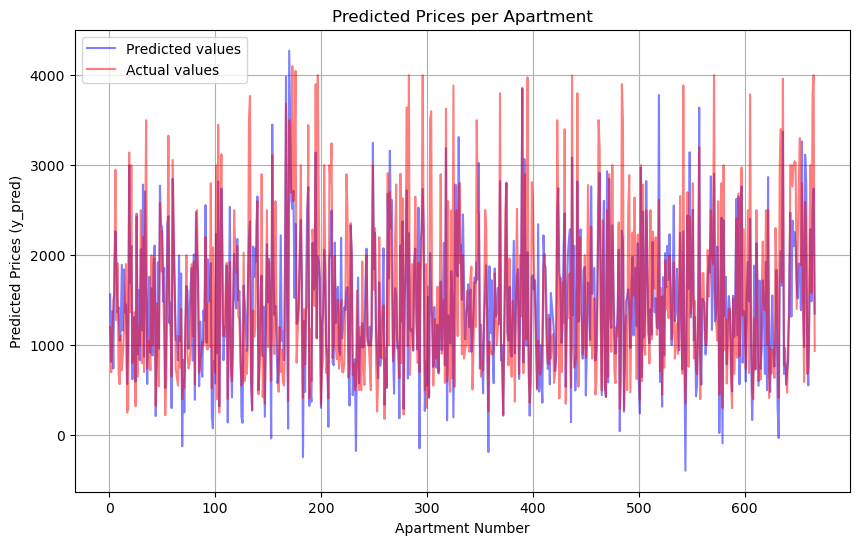

In [11]:
# Plot y_test vs y_pred
plt.figure(figsize=(10, 6))
plt.plot(np.array(range(1, len(y_pred)+1)),y_pred ,alpha=0.5, color='blue', label='Predicted values')
plt.plot(np.array(range(1, len(y_pred)+1)),y_test ,alpha=0.5, color='red', label='Actual values')
plt.xlabel('Apartment Number')
plt.ylabel('Predicted Prices (y_pred)')
plt.title('Predicted Prices per Apartment')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from sklearn.ensemble import RandomForestRegressor

if 'price' not in df.columns:
    raise ValueError("The 'price' column is not in the DataFrame.")

original_shape = df.shape
df = remove_outliers(df, 'price')
print(f"Outliers removed from 'price'. Original shape: {original_shape}, New shape: {df.shape}")

X = df.drop(columns=['price', 'id'])
y = df['price']

datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
for col in tqdm(datetime_cols, desc="Processing datetime columns"):
    X[col] = (X[col] - X[col].min()).dt.days

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {np.sqrt(mse):.2f}")
print(f"R-squared (R2): {r2:.2f}")


Outliers removed from 'price'. Original shape: (3328, 358), New shape: (3245, 358)


Processing datetime columns: 100%|██████████| 1/1 [00:00<?, ?it/s]


Mean Squared Error (MSE): 479.72
R-squared (R2): 0.66


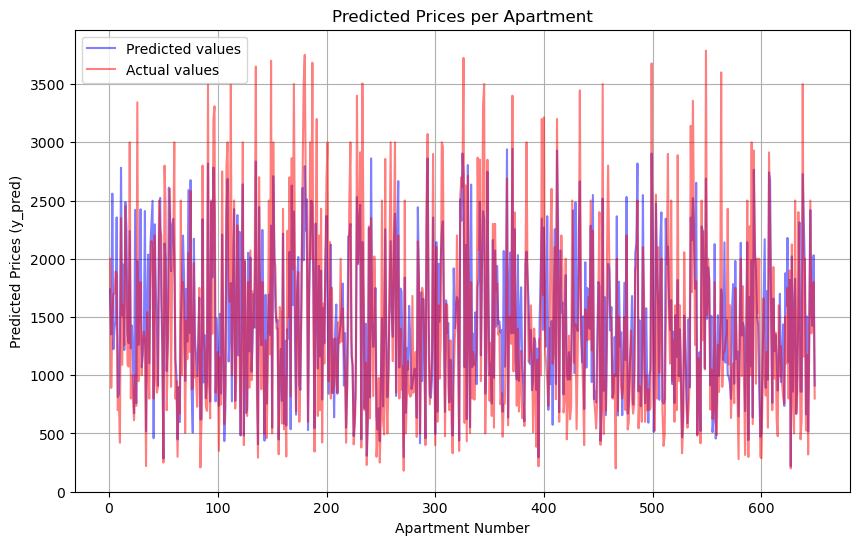

In [13]:
# Plot y_test vs y_pred
plt.figure(figsize=(10, 6))
plt.plot(np.array(range(1, len(y_pred)+1)),y_pred ,alpha=0.5, color='blue', label='Predicted values')
plt.plot(np.array(range(1, len(y_pred)+1)),y_test ,alpha=0.5, color='red', label='Actual values')
plt.xlabel('Apartment Number')
plt.ylabel('Predicted Prices (y_pred)')
plt.title('Predicted Prices per Apartment')
plt.legend()
plt.grid(True)
plt.show()

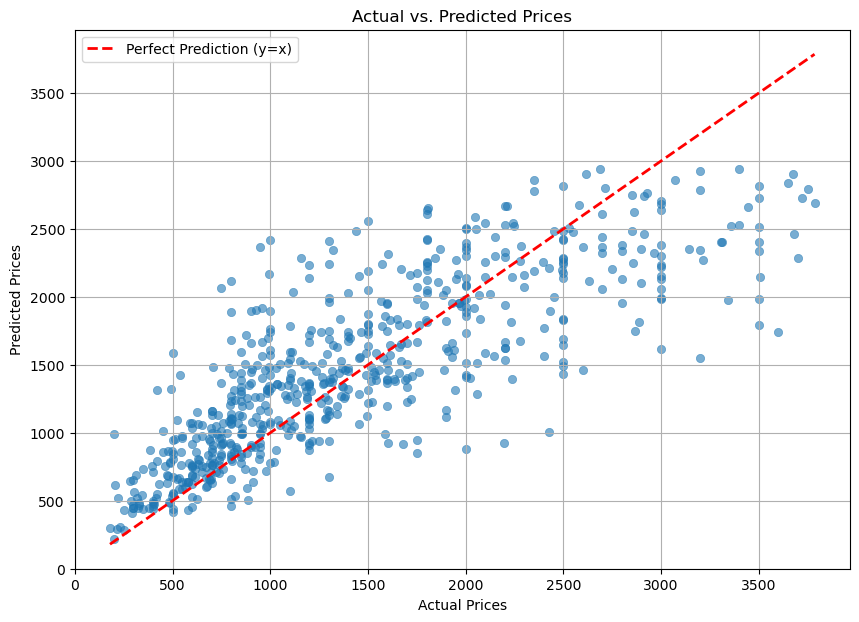

In [14]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)

# Add a line for perfect predictions (y=x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction (y=x)')

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#df.drop(columns=['host_location', 'host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'verifications_list'], inplace=True)

## LightGBM

In [16]:
# --- FIX: Sanitize feature names for LightGBM ---
print("Sanitizing feature names...")
original_columns = X.columns
new_column_names = []
for col in original_columns:
    # Replace special JSON characters (and other non-alphanumeric except underscore) with an underscore
    new_col = re.sub(r'[^A-Za-z0-9_]+', '_', str(col))
    new_col = re.sub(r'_{2,}', '_', new_col) 
    new_col = new_col.strip('_')  
    if new_col and new_col[0].isdigit():
        new_col = 'col_' + new_col
    if not new_col:
        new_col = f"unnamed_feature_{len(new_column_names)}"
    new_column_names.append(new_col)

X_train.columns = new_column_names
X_test.columns = new_column_names
print("Feature name sanitization complete.")

Sanitizing feature names...
Feature name sanitization complete.


In [17]:
X_train_tuned, X_val, y_train_tuned, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42 # 20% of X_train used for validation
)
print(f"\nShape of X_train_tuned: {X_train_tuned.shape}")
print(f"Shape of X_val: {X_val.shape}")


# --- 3. Hyperparameter Tuning with RandomizedSearchCV and Early Stopping ---
print("\nStarting LightGBM hyperparameter tuning with RandomizedSearchCV...")

# Initialize LGBMRegressor with fixed parameters
# n_estimators will be optimized by early stopping, so we set a high initial value.
lgbm = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',             # Evaluation metric for early stopping
    random_state=42,
    n_jobs=-1,                 # Use all available cores for training
    verbose=-1                 # Suppress verbose output during individual model training
)

# Define the parameter distribution for RandomizedSearchCV
# We use uniform distributions (for continuous parameters) and randint (for integers)
param_dist = {
    'n_estimators': randint(500, 2500),       # Number of trees (boosting rounds), early stopping will optimize this
    'learning_rate': uniform(0.01, 0.1),      # Learning rate (from 0.01 to 0.11)
    'num_leaves': randint(5, 100),           # Maximum number of leaves in one tree (from 20 to 99)
    'max_depth': [-1, 10, 20, 30, 50],            # Maximum tree depth (-1 for no limit, or specific values)
    'min_child_samples': randint(5, 50),      # Minimum number of data needed in a child (leaf)
    'subsample': uniform(0.6, 0.4),           # Subsample ratio of the training instance (e.g., from 0.6 to 1.0)
    'colsample_bytree': uniform(0.6, 0.4),    # Subsample ratio of columns (e.g., from 0.6 to 1.0)
    'reg_alpha': uniform(0.0, 0.5),           # L1 regularization (alpha)
    'reg_lambda': uniform(0.0, 0.5)           # L2 regularization (lambda)
}

# Create a custom scorer for RMSE (Scikit-learn maximizes scores, so we'll use -RMSE)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
                          greater_is_better=False) # greater_is_better=False indicates that a lower value is better

# Configure RandomizedSearchCV
# n_iter: Number of parameter combinations to try. Since the model is fast, 100-200 is a good starting point.
# cv: Number of folds for cross-validation. We will use 3 folds, in addition to early stopping on the validation set.
n_iter_search = 250 # Number of iterations for the search

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring=rmse_scorer,      # The defined scorer for RMSE
    cv=3,                     # 3-fold cross-validation
    verbose=5,                # Show search progress
    random_state=42,
    n_jobs=-1                 # Use all cores to parallelize search iterations
)

# Parameters to pass to the .fit() method of the LGBMRegressor model
# Here we specify the validation set and callbacks for early stopping.
fit_params = {
    "eval_set": [(X_val, y_val)],
    "eval_metric": "rmse",
    "callbacks": [lgb.early_stopping(100, verbose=False)] # Stop if validation metric does not improve for 100 rounds
}

# Execute the search
random_search.fit(X_train_tuned, y_train_tuned, **fit_params)

print("\nHyperparameter tuning complete.")
print(f"Best parameters found: {random_search.best_params_}")
# best_score_ is -RMSE, so we negate it to get the actual RMSE value
print(f"Best RMSE on validation set (during tuning): {-random_search.best_score_:.4f}")


# --- 4. Using the Best Model Found ---
# random_search.best_estimator_ contains the LGBMRegressor model trained
# with the best hyperparameters and the number of n_estimators determined by early stopping.
best_lgbm_model = random_search.best_estimator_

print("\nUsing the best model for final predictions...")
# --- 5. Make Predictions ---
y_pred_gbm = best_lgbm_model.predict(X_test)
print("Predictions complete.")

# --- 6. Calculate RMSE on the Test Set ---
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
rmse_gbm = np.sqrt(mse_gbm)
print(f"\nLightGBM Root Mean Squared Error (RMSE) on test set: {rmse_gbm:.2f}")


Shape of X_train_tuned: (2076, 486)
Shape of X_val: (520, 486)

Starting LightGBM hyperparameter tuning with RandomizedSearchCV...
Fitting 3 folds for each of 250 candidates, totalling 750 fits

Hyperparameter tuning complete.
Best parameters found: {'colsample_bytree': 0.6288337343994693, 'learning_rate': 0.01712567277652586, 'max_depth': -1, 'min_child_samples': 9, 'n_estimators': 647, 'num_leaves': 25, 'reg_alpha': 0.19379761574138477, 'reg_lambda': 0.23097346833547788, 'subsample': 0.9966353635481096}
Best RMSE on validation set (during tuning): 469.4946

Using the best model for final predictions...
Predictions complete.

LightGBM Root Mean Squared Error (RMSE) on test set: 443.61


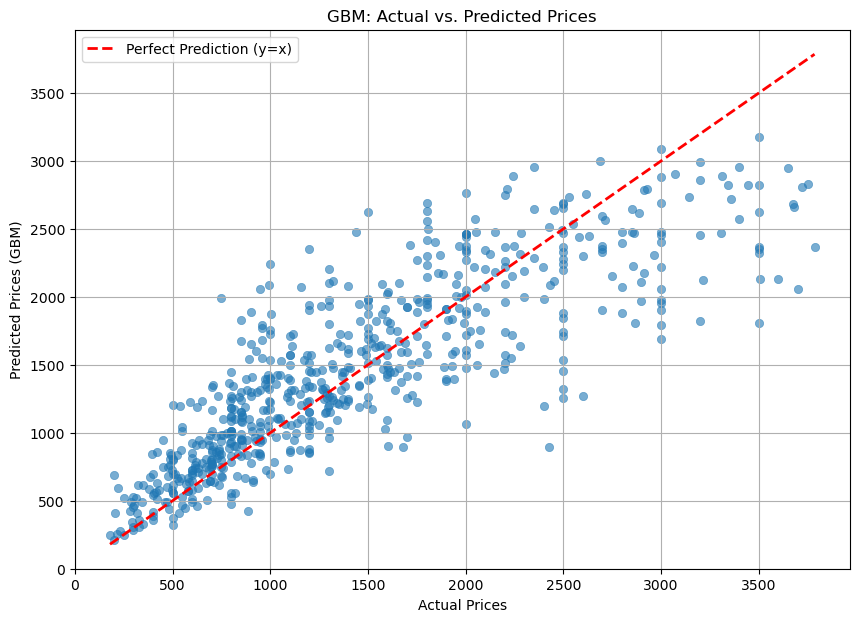

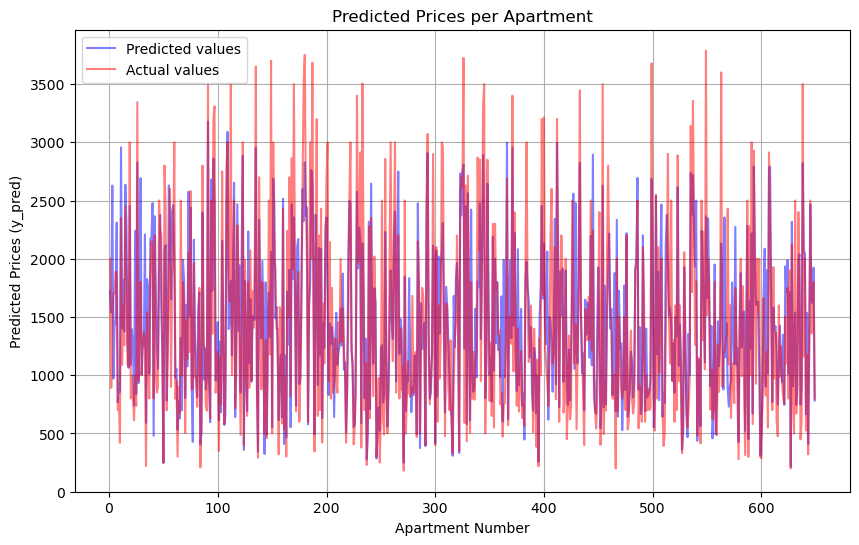

In [18]:
# --- 4. Data Visualization of Predictions ---

# a. Scatter Plot: Actual vs. Predicted Values
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_pred_gbm, alpha=0.6, edgecolor=None)
min_val_gbm = min(y_test.min(), y_pred_gbm.min())
max_val_gbm = max(y_test.max(), y_pred_gbm.max())
plt.plot([min_val_gbm, max_val_gbm], [min_val_gbm, max_val_gbm], color='red', linestyle='--', lw=2, label='Perfect Prediction (y=x)')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices (GBM)")
plt.title("GBM: Actual vs. Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()

# Plot y_test vs y_pred
plt.figure(figsize=(10, 6))
plt.plot(np.array(range(1, len(y_pred_gbm)+1)),y_pred_gbm ,alpha=0.5, color='blue', label='Predicted values')
plt.plot(np.array(range(1, len(y_pred_gbm)+1)),y_test ,alpha=0.5, color='red', label='Actual values')
plt.xlabel('Apartment Number')
plt.ylabel('Predicted Prices (y_pred)')
plt.title('Predicted Prices per Apartment')
plt.legend()
plt.grid(True)
plt.show()